# Chapter 3: Transfer Learning - German Traffic Sign Recognition Benchmark (GTSRB)

#### Imports 

In [59]:
#files 
from glob import glob 
import shutil 
from pathlib import Path

# linalg
import numpy as np 

# images 
import cv2

# plotting 
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt 
import seaborn as sns 
from pylab import rcParams

# dataframes 
import pandas as pd

# sklearn 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report 

#progress bar 
from tqdm import tqdm 

# nice colors
import termcolor
from termcolor import colored

# pytorch
import torch, torchvision
from torch import nn, optim 

# functional
import torch.nn.functional as F 

# utils
import torchvision.transforms as T
import PIL.Image as Image
from torch.optim import lr_scheduler
from collections import defaultdict

# datasets 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader 

# models 
from torchvision import models 

In [5]:
# getting the specific device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev_name = torch.cuda.get_device_name()
print(dev_name)

Tesla K80


In [6]:
# setting the figure size 
rcParams['figure.figsize'] = 12,8

#### Getting the GTSRB Dataset

This dataset contains 42 classes of German traffic signs and we will use Transfer Learning to improve on a vainilla model. 

In [7]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

--2022-01-26 18:26:49--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  11.1MB/s    in 26s     

2022-01-26 18:27:16 (9.99 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [8]:
# Unzipping 
!unzip -qq "./GTSRB_Final_Training_Images.zip"

In [9]:
# setting the path to the image folders 
IMG_FOLDER = '/content/GTSRB/Final_Training/Images'

# getting all the classes 
train_folders = sorted(glob(IMG_FOLDER+'/*'))
# number of classes
print(f"We have {len(train_folders)} classes")

We have 43 classes


#### Helper Functions

In [10]:
# Helper functions - 3 total !  

# 1 - loading the image 
def load_image(PATH, resize=True,size=(64,64)):
  '''
  Helper function to load the image and resize it to 64x64 in case that is needed, or one can also 
  define the specific shape
  '''
  # loading the image and loading it into RGB
  img = cv2.cvtColor(cv2.imread(PATH), cv2.COLOR_BGR2RGB)

  # resizing and interpolate 
  if resize: 
    img = cv2.resize(img, (size[0], size[1]), interpolation=cv2.INTER_AREA)
  
  return img


# 2 - show image 
def show_img(PATH):
  '''
  Helper function to visualize an image 
  '''
  # loading the image with the previous function 
  img = load_image(PATH)
  # showing the image 
  plt.imshow(img)
  plt.axis('off')


# 3 - make grid with different signs 

def make_traffic_grid(PATHS):
  '''
  Helper function which makes a grid to visualize 11 * 4 images (44 total)
  '''
  # loop through the paths we give it and load the images + make into array 
  loaded_images = np.array([load_image(img) for img in PATHS])
  # convert it to tensors 
  loaded_images = torch.as_tensor(loaded_images)
  # permuting them - changing the RGB --> BGR
  loaded_images = loaded_images.permute(0,3,1,2)
  # make a grid 
  img_grid = torchvision.utils.make_grid(loaded_images, nrow=11)
  # make the figure for the grid 
  plt.figure(figsize=(24,12))
  # show the image 
  plt.imshow(img_grid.permute(1,2,0))
  # turning off the axis 
  plt.axis('off')


def make_folders_data(CLASS,DATA_DIR, DATA_SETS):
  '''
  Helper function which makes a folder for the specific classes and the 
  specific phase (train, test, val )

  '''
  # data directory 
  ddir = Path(DATA_DIR)
  
  # looping 
  for k in DATA_SETS:
    for y in CLASS:
      (ddir/k/y).mkdir(parents=True, exist_ok=True)

def split_data(CLASS_INDECES,CLASSES, DATA_SET, TRAIN_RATIO, VAL_RATIO, DEBUG=True, FILE_BUG=False):
  '''
  Helper function to split the data into 10% testing and validation and 80% training

  '''

  # looping through the index of the classes we chose 
  for idx, class_idx in enumerate(CLASS_INDECES):
    # making the image path an array 
    img_path = np.array(glob(f"{train_folders[class_idx]}/*.ppm"))
    # getting the specified class name 
    class_name = CLASSES[idx]
    # debugging 
    if DEBUG:
      print(f"\nThe class {class_name} has {len(img_path)} images.")
    # shuffling them 
    np.random.shuffle(img_path)
    # defining the ratios given the image path length (number of images)
    RATIOS = (int(TRAIN_RATIO*len(img_path)), int(VAL_RATIO*len(img_path)))
    # splitting them 
    data_split = np.split(
                          img_path, 
                          indices_or_sections=[RATIOS[0], RATIOS[1]]
                          )
    # zipping 
    dataset_data = zip(DATA_SET,data_split)
    #ddir 
    data_directory = Path('data')
    # moving the specified images 
    for d, imgs in dataset_data:
      for paths in imgs:
        shutil.copy(paths, f"{data_directory}/{d}/{class_name}")
        if FILE_BUG:
          print(f"Moved {paths} successfully !!!")


def show_image(INPUT,title=None):
  '''
  Helper function to visualize the transformations that were done 

  '''
  # transposing the image 
  input = INPUT.numpy().transpose((1,2,0))
  # reverting the normalization 
  means = np.array([meanies])
  st_dev = np.array([stds])
  # de-normalize
  input = st_dev * input + means
  # clipping
  input = np.clip(input, 0, 1)
  # showing 
  plt.imshow(input)
  if title is not None:
    plt.title(title)
  plt.axis('off')

#### Visualize the Dataset

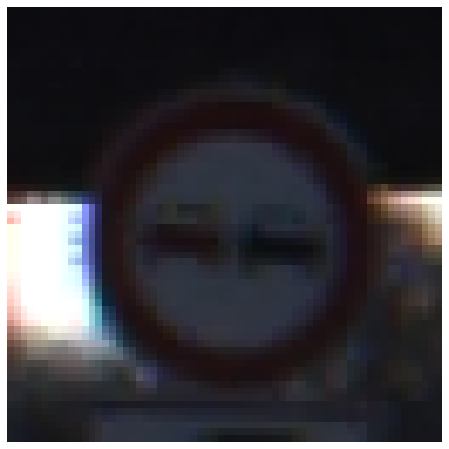

In [14]:
# lets visualize a single example 
CLASS = 9
sample_image = glob(train_folders[CLASS] + '/*ppm')[0]
show_img(sample_image)

Number of samples : 43


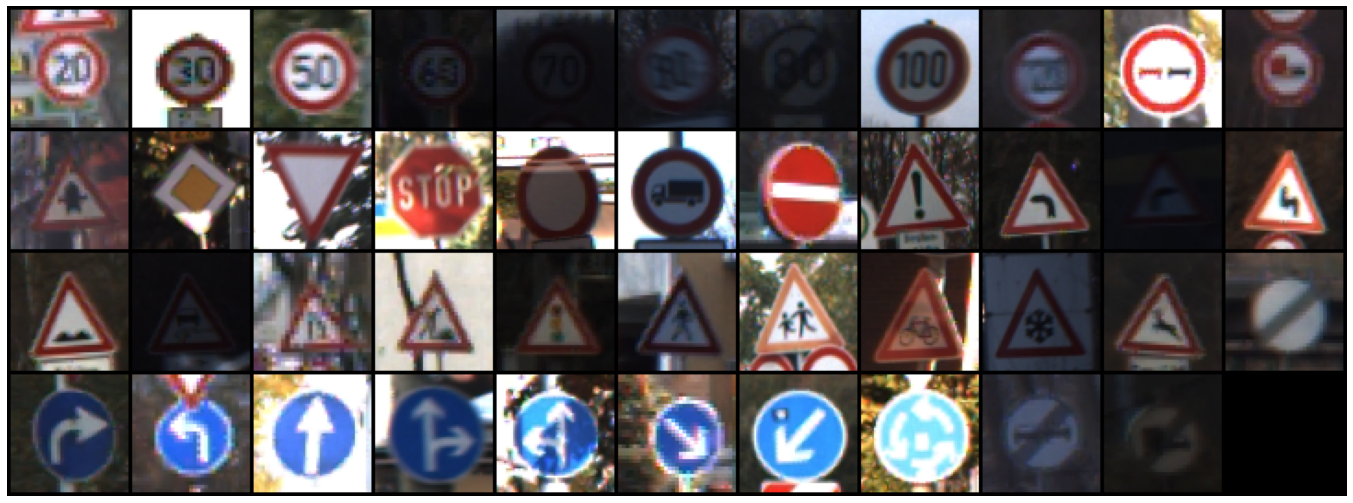

In [15]:
# get the random ramples 
sample_images = [np.random.choice(glob(f"{x}/*ppm")) for x in train_folders]
print(f"Number of samples : {len(sample_images)}")

# now let's make a grid for these 
make_traffic_grid(sample_images)

#### Sepparating the Images

In [16]:
# we will use specific classes for this 
classes = ['priority_road','give_way','stop','no_entry']

# and their corresponding indices 
class_index = [12,13,14,17]

# datasets - train test val 
DATASETS = ['train','test','val']

# making folders 
make_folders_data(classes, 'data',DATASETS)

# splitting the data
split_data(class_index, classes, DATASETS,0.8, 0.9, DEBUG=True,FILE_BUG=False)


The class priority_road has 2100 images.

The class give_way has 2160 images.

The class stop has 780 images.

The class no_entry has 1110 images.


#### Image Transformations

In [17]:
# we will use the standard deviations and means that are given by torchvision
# means 
meanies = [0.485,0.456,0.406]
# standard deviations 
stds = [0.229, 0.224, 0.225]

# making a transformations dictionary 
# transformations included: 
# - Random Resized crop 
# - Random Rotation 
# - Center Crop 
# - Normalization 
transforms = {
              "train":T.Compose([
                                 T.RandomResizedCrop(size=256),
                                 T.RandomRotation(degrees=15),
                                 T.RandomHorizontalFlip(),
                                 T.ToTensor(),
                                 T.Normalize(meanies, stds)
                                 ]),
              
              "val":T.Compose([
                              T.Resize(size=256),
                               T.CenterCrop(size=224),
                               T.ToTensor(),
                               T.Normalize(meanies, stds) 
                              ]),
              
              "test":T.Compose([
                                T.Resize(size=256),
                                T.CenterCrop(size=224),
                                T.ToTensor(),
                                T.Normalize(meanies, stds)
                                ])
              }

#### Making the datasets

In [18]:
data_dir = Path('data')
# create a pytorch dataset for each of the images 
image_datasets = {
                  k: ImageFolder(f"{data_dir}/{k}",transforms[k]) for k in DATASETS
                  }
# make a dataloader out of the datasets 
data_loaders = {
                o: DataLoader(image_datasets[o],batch_size=4, shuffle=True,num_workers=2) for o in DATASETS
                }

# we can extract the size of the dataset
size_ds = {d: len(image_datasets[d]) for d in DATASETS}
# also the class names 
class_names = image_datasets['train'].classes

#### Visualizing the Image Transformations

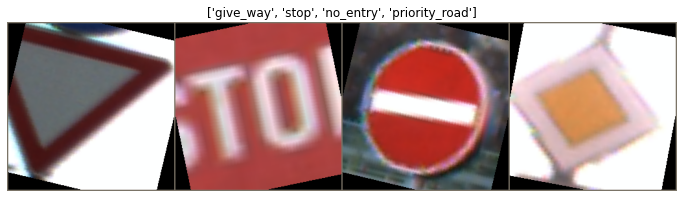

In [21]:
# iterate over one of the dataloaders 
targets, labels = next(iter(data_loaders['train']))
# make a grid 
out_grid = torchvision.utils.make_grid(targets)
# lets show the images 
show_image(out_grid, title=[class_names[x] for x in labels])

#### Making the model - Transfer Learning

In [22]:
# make model function 
def make_model(n_classes):
  '''
  Helper function to use a pretrained model with the GTSRB
  '''
  model = models.resnet34(pretrained=True)
  # stating the number of features 
  n_features = model.fc.in_features 
  # chaning the model fully connected 
  model.fc = nn.Linear(n_features, n_classes)
  return model.to(device)

# number of classes
NUM_CLASSES = len(class_names)
# making the base model 
base_model = make_model(NUM_CLASSES)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

#### Training - Testing - Validation Helper Functions

# TRAINING

In [39]:
def train_loop(MODEL, DATA_LOADER, LOSS_FUNCTION, OPTIMIZER, DEVICE, SCHEDULER, EXAMPLES):
  '''
  Helper function which trains the model with the given loss function, optimizer, and scheduler. 
  Training on the specified DATA_LOADER and with number of examples 
  '''
  # putting into training mode 
  model = MODEL.train()
  # accumulate the losses 
  running_loss = []
  # correctly predicted counter
  correct_preds = 0
  # going over out dataloader 
  for inputs, targets in DATA_LOADER:
    # sending to device 
    inputs = inputs.to(DEVICE)
    targets = targets.to(DEVICE)
    # predicting an output 
    y_pred = MODEL(inputs)
    # getting the max 
    _, preds = torch.max(y_pred, dim=1)
    # getting the loss 
    loss = LOSS_FUNCTION(y_pred, targets)
    # correct prediction 
    correct_preds+= torch.sum(preds == targets)
    # appending the loss 
    running_loss.append(loss.item())
    # zeroing grads 
    OPTIMIZER.zero_grad()
    # sending the loss backwards 
    loss.backward()
    # stepping
    OPTIMIZER.step()
    #print(num_corr, avg_loss)
  # step the scheduler 
  SCHEDULER.step()
  # number correct 
  num_corr = correct_preds.double()/EXAMPLES
  avg_loss = np.mean(running_loss)
  
  return num_corr, avg_loss

# EVALUTATION

In [40]:
# Evaluate the model 
def val_loop(MODEL, DATA_LOADER, LOSS_FUNCTION, DEVICE, EXAMPLES):
  '''
  Helper function to evaluate the model 

  '''
  # setting into eval mode 
  model = MODEL.eval()
  # accumulate the loss and predictions 
  running_loss = []
  corr_preds = 0
  # loop 
  with torch.no_grad():
    for inputs, targets in DATA_LOADER:
      # sending to deivce 
      inputs = inputs.to(DEVICE)
      targets = targets.to(DEVICE)
      # prediction 
      y_pred = MODEL(inputs)
      # max vls 
      _, preds = torch.max(y_pred, dim=1)
      #loss 
      loss = LOSS_FUNCTION(y_pred, targets)
      # correct predictions
      corr_preds += torch.sum(preds == targets)
      # keep track of loss 
      running_loss.append(loss.item())
      # correct 
      num_corr = corr_preds.double() / EXAMPLES
      avg_loss = np.mean(running_loss)
  return num_corr, avg_loss

# TRAINING LOOP

In [43]:
def train_model(MODEL, DATA_LOADER, DATASET_SIZES, DEVICE, EPOCHS=3):
  '''
  Helper Function to train the model with the training and evaluation loop 

  '''
  # defin our optimizer
  optimizer = optim.SGD(MODEL.parameters(), lr = 0.001, momentum=0.9)
  # define our scheduler 
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  # define our loss function 
  loss_fn = nn.CrossEntropyLoss().to(DEVICE)
  # history 
  history = defaultdict(list)
  best_acc = 0
  for epoch in range(EPOCHS):
    # keep track of epochs 
    print(f"\nEpoch: {epoch+1}/{EPOCHS}")
    # TRAINING
    train_acc, train_loss = train_loop(MODEL, DATA_LOADER['train'], loss_fn, optimizer, DEVICE, scheduler, DATASET_SIZES['train'])
    train_txt = f"\nTRAINING: LOSS:{train_loss} ACCURACY: {train_acc}"
    print(colored(train_txt, 'red','on_white'))
    # VALIDATION
    val_acc, val_loss = val_loop(MODEL, DATA_LOADER['val'], loss_fn, DEVICE, DATASET_SIZES['val'])
    val_txt = f"\nVALIDATION: LOSS:{val_loss} ACCURACY: {val_acc}"
    print(colored(val_txt, 'green','on_grey'))
    # keeping track of the data 
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # keeping the best accuracy so far 
    if val_acc > best_acc:
      torch.save(MODEL.state_dict(), "best_model_state.bin")
      best_acc = val_acc
  print(f"\nTHE BEST ACCURACY: {best_acc}")
    # loading the best model 
  MODEL.load_state_dict(torch.load('best_model_state.bin'))
  return MODEL, history

In [44]:
base_model, history = train_model(base_model, data_loaders, size_ds, device)


Epoch: 1/3

TRAINING: LOSS:0.05681165572400275 ACCURACY: 0.9817073170731707

VALIDATION: LOSS:0.004216150927070821 ACCURACY: 0.9983739837398374

Epoch: 2/3

TRAINING: LOSS:0.054183467861499905 ACCURACY: 0.983130081300813

VALIDATION: LOSS:0.0028477875562376307 ACCURACY: 1.0

Epoch: 3/3

TRAINING: LOSS:0.0534301981483763 ACCURACY: 0.9853658536585366

VALIDATION: LOSS:0.0037492613879549423 ACCURACY: 0.9983739837398374

THE BEST ACCURACY: 1.0


#### Visualize the History

In [46]:
def plot_history(HISTORY,SIZE=(18,6)):
  # creating the figure 
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=SIZE)
  # LOSS
  ax1.plot(history['train_loss'], label='Train Loss')
  ax1.plot(history['val_loss'], label='Val Loss')
  # setting the ticks 
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  # labels
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')
  # ACCURACY 
  ax2.plot(history['train_acc'], label='Train Accuracy')
  ax2.plot(history['val_acc'], label='Val Accuracy')
  # setting the ticks 
  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()
  # lables
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  #Title
  fig.suptitle('Training history')

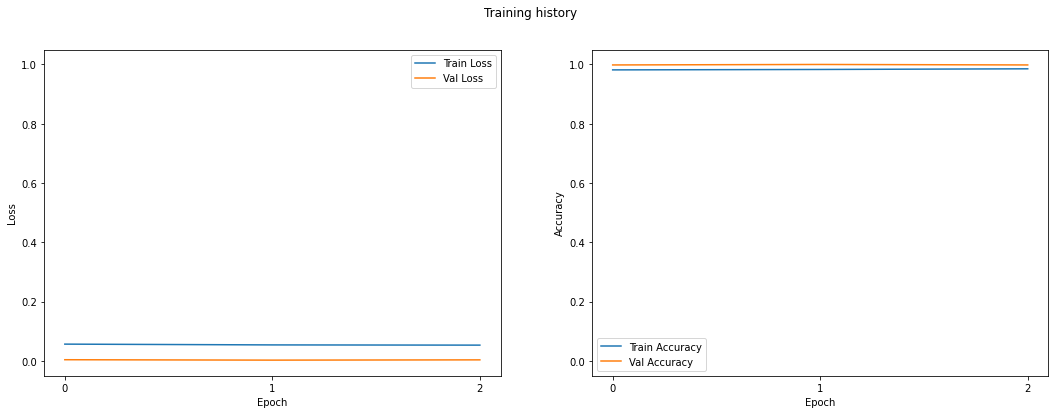

In [47]:
plot_history(history)

#### Visualize Predictions

In [54]:
# we are going to show predictions on the test set now 
def show_predictions(MODEL, CLASS_NAMES, N_IMAGES=6):
  # eval mode 
  MODEL.eval()
  # counter
  imgs = 0 
  # create a figure 
  plt.figure()

  # with no grad 
  with torch.no_grad():
    for idx, (inputs, targets) in enumerate(data_loaders['test']):
      # to device 
      inputs = inputs.to(device)
      targets = targets.to(device)
      #preds
      outputs = MODEL(inputs)
      # getting the max 
      _, pred = torch.max(outputs, dim=1)
      # now let's check the predictions 
      for k in range(inputs.shape[0]):
        imgs+=1
        ax = plt.subplot(2, N_IMAGES//2, imgs)
        ax.set_title(f"Predicted: {class_names[pred[k]]}")
        show_image(inputs.cpu().data[k])
        ax.axis('off')
        if imgs == N_IMAGES:
          return 

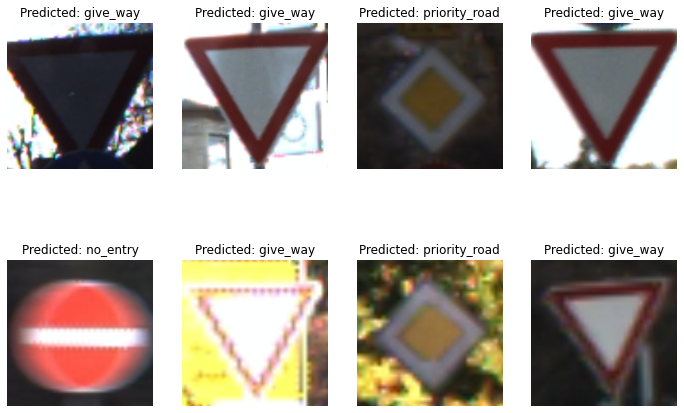

In [55]:
show_predictions(base_model, class_names, N_IMAGES=8)

#### Getting the actual predictions 

In [56]:
def get_preds(MODEL, DATA_LOADER):
  model = MODEL.eval()
  predictions = []
  real_vals = []
  with torch.no_grad():
    for inputs, targets in DATA_LOADER:
      inputs = inputs.to(device)
      targets = targets.to(device)
      outputs=model(inputs)
      _, preds = torch.max(outputs, dim=1)
      predictions.extend(preds)
      real_vals.extend(targets)
  predictions = torch.as_tensor(predictions).cpu()
  real_vals = torch.as_tensor(real_vals).cpu()
  return predictions, real_vals

In [57]:
y_pred, y_test = get_preds(base_model, data_loaders['test'])

#### Classification Report + Matrix

In [58]:
# classification report 
cr = classification_report(y_test, y_pred, target_names=class_names)
print(cr)


               precision    recall  f1-score   support

     give_way       1.00      1.00      1.00       216
     no_entry       1.00      0.99      1.00       111
priority_road       1.00      1.00      1.00       210
         stop       1.00      1.00      1.00        78

     accuracy                           1.00       615
    macro avg       1.00      1.00      1.00       615
 weighted avg       1.00      1.00      1.00       615



In [60]:
# classification matrix 
def show_cm(CM, NAMES):
  # copying the confustion matrix
  cm = CM.copy()
  # counts 
  cell_counts = cm.flatten()
  # normalize 
  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]
  #percentages
  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]
  # labels 
  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])
  # dataframe 
  df = pd.DataFrame(cm_row_norm, index=NAMES, columns=NAMES)
  #heatmap 
  hmap = sns.heatmap(df, annot=cell_labels, fmt="", cmap="Blues")
  # ticks
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  # labels 
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign')

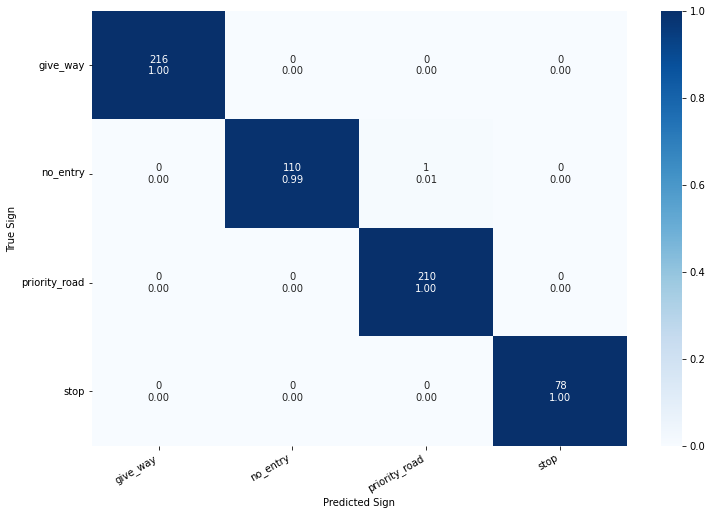

In [61]:
# make the confusion matrix 
cm = confusion_matrix(y_test, y_pred)
# showing it 
show_cm(cm,class_names)

# Predict on Unseen Images

In [65]:
# we need to get the probabilities for each of the classes 
def get_pred_proba(MODEL, PATH):
  # reading and converting the images 
  img = Image.open(PATH)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)
  img = img.to(device)
  # predicting 
  pred = MODEL(img)
  pred = F.softmax(pred, dim=1)
  pred = pred.detach().cpu().numpy().flatten()
  return pred

# define another function to plot it as it returns an array 
def plot_pred_proba(PRED, NAMES):
  pred_df = pd.DataFrame(
                        {
                          'Class_Name':NAMES,
                          'Values':PRED
                          })
  sns.barplot(x='Values',y='Class_Name',data=pred_df,orient='h')
  plt.xlim([0,1])
  plt.show()

In [67]:
!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
!gdown --id 1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u

Downloading...
From: https://drive.google.com/uc?id=19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
To: /content/stop-sign.jpg
100% 77.3k/77.3k [00:00<00:00, 73.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u
To: /content/unknown-sign.jpg
100% 41.4k/41.4k [00:00<00:00, 16.1MB/s]


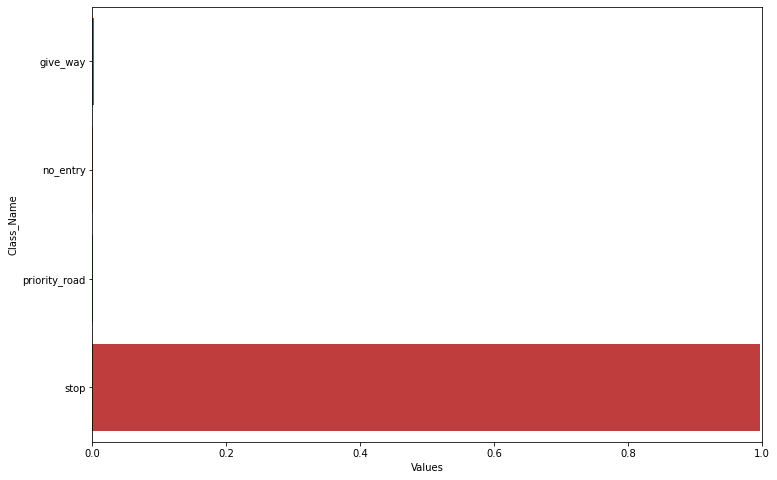

In [66]:
# getting the prediction and then visualizing it 
predz = get_pred_proba(base_model, 'stop-sign.jpg')
# visualize 
plot_pred_proba(predz, class_names)

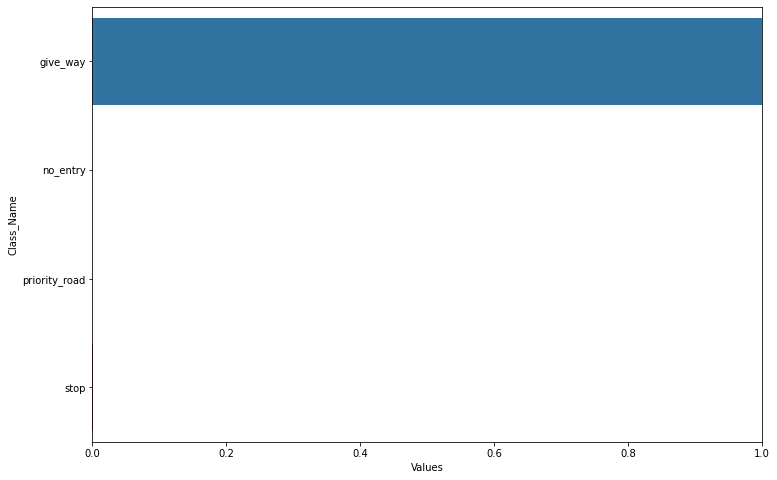

In [68]:
# getting the prediction and then visualizing it 
predz = get_pred_proba(base_model, 'unknown-sign.jpg')
# visualize 
plot_pred_proba(predz, class_names)